In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [2]:
# -- import --
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW, ElectraTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report
# GPU 사용
device = torch.device("cuda")

In [3]:
# -- 필요 데이터 --
import pandas as pd

def bring_and_preprocess_df():
    # -- 상대적으로 개수가 적은 csv 파일 사용 --
    df = pd.read_csv('/content/drive/MyDrive/reduced_twice_bungae_df.csv', encoding='utf-8-sig')
    df['cat_id'] = df['cat_id'].astype(int).astype(str)

    # -- 패션과 관련 없는 카테고리 제거 --
    idx_list = list()
    for idx in range(len(df)):
        if (len(df.loc[idx, 'cat_id']) == 3) | (df.loc[idx, 'cat_id'][0] not in ['3', '4']):
            idx_list.append(idx)

    df = df[~df.index.isin(idx_list)]
    # -- 카테고리당 상품이 1~2개 있을 경우 train_test_split 했을 때 갯수가 너무 적어 안됨, 이후에 수정 필요 --
    df = df[~df['cat_id'].isin(['310060999', '310220999', '320180500'])]

    df = df.dropna(axis=0)
    df = df.reset_index(drop=True)
    df = df.iloc[:, 2:]
    return df

# 축소 데이터
df = bring_and_preprocess_df()
df['main_cat'] = df['cat_id'].apply(lambda x : x[:3]) # main_cat으로 분리해보기
df.head()

,product_id,product_name,image_url,image_cnt,cat_id,main_cat
0,217365207,경량롱패딩,https://media.bunjang.co.kr/product/217365207_...,3.0,310090050,310
1,175507846,롱패딩 판매합니다,https://media.bunjang.co.kr/product/175507846_...,4.0,310090050,310
2,213094512,피레넥스 여성 화이트 패딩 55판-69,https://media.bunjang.co.kr/product/213094512_...,10.0,310090050,310
3,208884568,보브 다운패딩,https://media.bunjang.co.kr/product/208884568_...,2.0,310090050,310
4,164395818,에이글 코트타입 구스 자켓 L사이즈,https://media.bunjang.co.kr/product/164395818_...,5.0,310090050,310


In [4]:
# -- preprocessing --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# format changes
df['product_name'] = "[CLS] " + df['product_name'] + " [SEP]"

# encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['main_cat'])

# train, test dataset split
train_x, test_x, train_y, test_y = train_test_split(df['product_name'], df['label'].values, random_state=42, test_size=.2)
train_df, test_df = df.loc[train_x.index], df.loc[test_x.index]


In [5]:
# -- converting inputs --
def convert_input(sentences):
    tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

input_ids, attention_masks = convert_input(train_df['product_name'])

In [6]:
# -- train and validation set --
def split_train_and_validation(input_ids, attention_masks):
    train_x, val_x, train_y, val_y = train_test_split(input_ids, train_df['label'].values, random_state=5, test_size=.2)
    train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=5, test_size=.2)

    # tensor로 만들기
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    train_mask = torch.tensor(train_mask)

    val_x = torch.tensor(val_x)
    val_y = torch.tensor(val_y)
    val_mask = torch.tensor(val_mask)

    # dataloader
    batch_size = 32
    train_data = TensorDataset(train_x, train_mask, train_y)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    val_data = TensorDataset(val_x, val_mask, val_y)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = split_train_and_validation(input_ids, attention_masks)

In [7]:
# -- setting device --
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
# -- koelectra_v3 --
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", num_labels=len(encoder.classes_))
model.cuda()

epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [9]:
from sklearn.metrics import accuracy_score
# -- model training --
# 시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# 그래디언트 초기화
model.zero_grad()
loss_list, acc_list = [], []
for epoch in tqdm(range(0, epochs)):
    # 로스 초기화
    total_loss = 0
    # 훈련모드
    model.train()
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # Forward 수행
        outputs = model(input_ids= b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # Backward 수행으로 그래디언트 계산
        loss.backward()
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()
        # 스케줄러로 학습률 감소
        scheduler.step()
        # 그래디언트 초기화
        model.zero_grad()
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)

    # 평가모드
    model.eval()
    # 변수 초기화
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            # 로스 구함
        logits = outputs.logits
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate accuracy
        predictions = np.argmax(logits, axis=1)
        accuracy = accuracy_score(label_ids, predictions)
        eval_accuracy += accuracy
        nb_eval_steps += 1

    acc_list.append(round(eval_accuracy / nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
# -- 모델 저장 --
PATH = '/content/drive/MyDrive/'
torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'all.tar')

Accuracy : 0.88


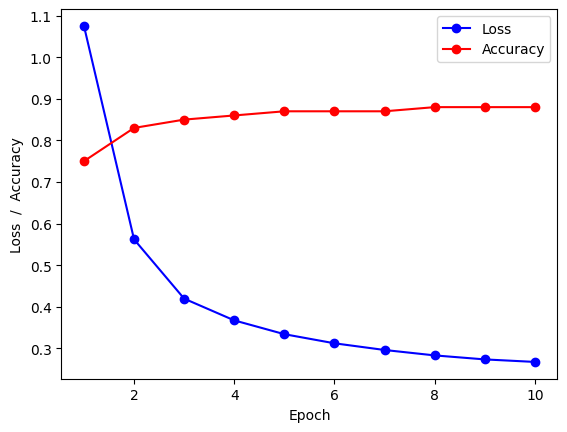

In [11]:
epoch = range(1, epochs+1)
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 2)}')

In [16]:
# -- 전이 학습 --
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH + 'model.pt')  # 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/model_state_dict.pt'))

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [17]:
def test_sentences(sentences):
    model.eval()
    # 문장을 입력 데이터로 변환
    input_ids, attention_masks = convert_input(sentences)
    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    return predictions

In [20]:
# -- test data에 적용 --
test_df = test_df.reset_index(drop=True)

for idx in tqdm(range(len(test_df))):
    preds = test_sentences([test_df.product_name[idx]])
    test_df.loc[idx, 'predicted'] = preds

test_df

  0%|          | 0/20034 [00:00<?, ?it/s]

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,label,predicted
0,219403284,[CLS] ripndip 블랙비니 립앤딥 비니 스투시 퍼킹어썸 [SEP],https://media.bunjang.co.kr/product/219403284_...,3.0,400070500,400,2,2.0
1,215848130,[CLS] 지오지아 구스 패딩자켓 남100 [SEP],https://media.bunjang.co.kr/product/215848130_...,6.0,320080700,320,1,1.0
2,224962818,[CLS] 미사용 국방부장관 시계 대장 국방부 [SEP],https://media.bunjang.co.kr/product/224962818_...,4.0,420100200,420,4,4.0
3,188653043,[CLS] 투티에 파라렐리자드 브라운 [SEP],https://media.bunjang.co.kr/product/188653043_...,9.0,430100100,430,5,0.0
4,224663653,[CLS] 디스퀘어드2 타이디바이커 진 [SEP],https://media.bunjang.co.kr/product/224663653_...,5.0,320110200,320,1,1.0
...,...,...,...,...,...,...,...,...
20029,223349801,[CLS] 스웨이드부츠 230 [SEP],https://media.bunjang.co.kr/product/223349801_...,5.0,405200200,405,3,3.0
20030,212532679,[CLS] 리바이스 엔지니어드자켓 S [SEP],https://media.bunjang.co.kr/product/212532679_...,10.0,320090200,320,1,1.0
20031,181159102,[CLS] 1990s Roots Athletic Olympic Fleece cap ...,https://media.bunjang.co.kr/product/181159102_...,5.0,400070999,400,2,1.0
20032,197383668,[CLS] 구하기힘든 통가죽 벨트 입니다 [SEP],https://media.bunjang.co.kr/product/197383668_...,12.0,400110100,400,2,2.0


In [22]:
accuracy = 0
for idx in tqdm(range(len(test_df))):
    if test_df.loc[idx, 'label'] == test_df.loc[idx, 'predicted']:
        accuracy += 1
print(accuracy / len(test_df))

  0%|          | 0/20034 [00:00<?, ?it/s]

0.8783068783068783
